## Task 1 (2 points + 1 bonus point + 1 super-bonus point)

(Titanic data again)

Build a model with `sklearn`'s `LogisticRegression` to get the accuracy of at least 0.80 (0.82 for the bonus point, 0.85 for the super-bonus point) on the test set.

Some (optional) suggestions:
- Add new features (e.g. missing value indicator columns)
- Fill missing values
- Encode categorical features (e.g. one-hot encoding)
- Scale the features (e.g. with standard or robust scaler)
- Think of other ways of preprocessing the features (e.g. `Fare` $\to$ `log(Fare)`)
- Try adding polynomial features



In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

data = pd.read_csv("train.csv", index_col='PassengerId')
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### About the data
Here's some of the columns
* Name - a string with person's full name
* Survived - 1 if a person survived the shipwreck, 0 otherwise.
* Pclass - passenger class. Pclass == 3 is cheap'n'cheerful, Pclass == 1 is for moneybags.
* Sex - a person's gender
* Age - age in years, if available
* SibSp - number of siblings on a ship
* Parch - number of parents on a ship
* Fare - ticket cost
* Embarked - port where the passenger embarked
 * C = Cherbourg; Q = Queenstown; S = Southampton

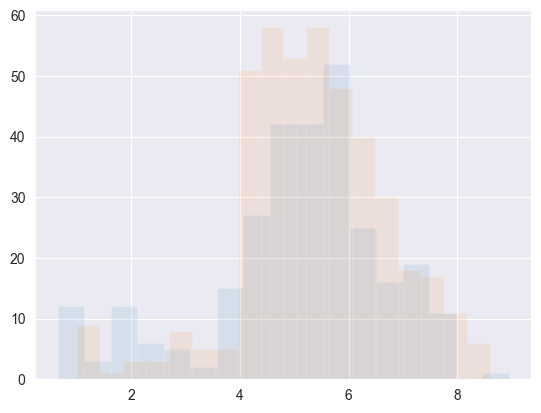

In [93]:
plt.hist(np.sqrt(data[data.Survived == 1].Age), bins='auto', alpha=0.1)
plt.hist(np.sqrt(data[data.Survived == 0].Age), bins='auto', alpha=0.1)
plt.show()

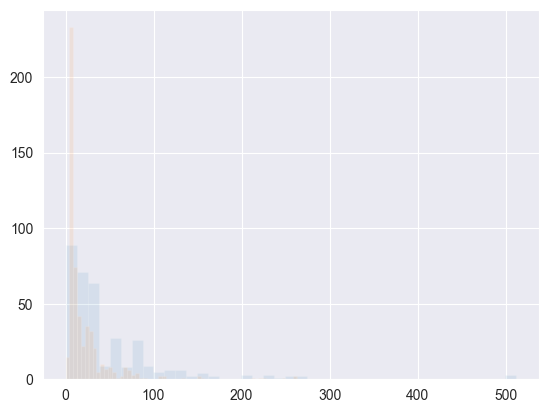

In [4]:
plt.hist(data[data.Survived == 1].Fare, bins='auto', alpha=0.1)
plt.hist(data[data.Survived == 0].Fare, bins='auto', alpha=0.1)
plt.show()

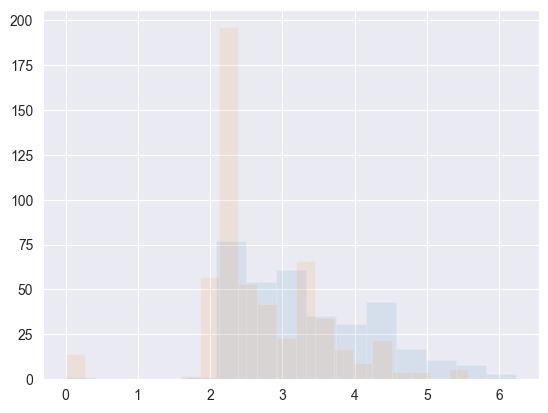

In [5]:
plt.hist(np.log(data[data.Survived == 1].Fare+1), bins='auto', alpha=0.1)
plt.hist(np.log(data[data.Survived == 0].Fare+1), bins='auto', alpha=0.1)
plt.show()

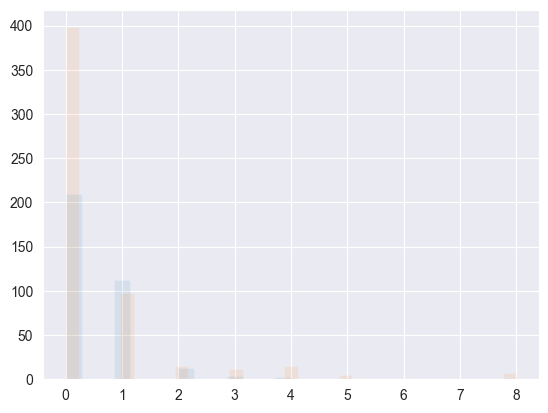

In [6]:
plt.hist(data[data.Survived == 1].SibSp, bins='auto', alpha=0.1)
plt.hist(data[data.Survived == 0].SibSp, bins='auto', alpha=0.1)
plt.show()

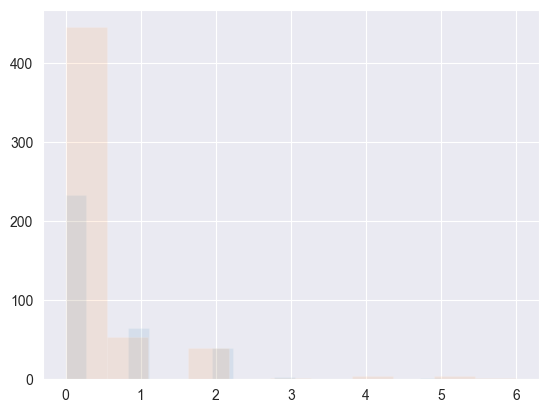

In [7]:
plt.hist(data[data.Survived == 1].Parch, bins='auto', alpha=0.1)
plt.hist(data[data.Survived == 0].Parch, bins='auto', alpha=0.1)
plt.show()

In [8]:
data.Name.apply(lambda x: x.split(',')[1].split('.')[0]).apply(lambda y: 'other' if y in (data.Name.apply(lambda x: x.split(',')[1].split('.')[0]).value_counts())[(data.Name.apply(lambda x: x.split(',')[1].split('.')[0]).value_counts() == 1)] else y)

PassengerId
1         Mr
2        Mrs
3       Miss
4        Mrs
5         Mr
       ...  
887      Rev
888     Miss
889     Miss
890       Mr
891       Mr
Name: Name, Length: 891, dtype: object

In [9]:
(data.Name.apply(lambda x: x.split(',')[1].split('.')[0]).value_counts())[(data.Name.apply(lambda x: x.split(',')[1].split('.')[0]).value_counts() != 1)]

Name
 Mr        517
 Miss      182
 Mrs       125
 Master     40
 Dr          7
 Rev         6
 Mlle        2
 Major       2
 Col         2
Name: count, dtype: int64

In [10]:
data['Surname'] = data.Name.apply(lambda x: x.split(',')[0])

In [11]:
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Montvila
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Graham
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Johnston


In [12]:
family_survival_dict = {}
has_survived_family = {}

for index, row in data.iterrows():
    last_name = row['Name'].split(',')[0]
    family_members_survived = data[(data['Name'].str.contains(last_name)) & (data['Survived'] == 1) & (index != data.index)]
    family_survival_dict[last_name] = len(family_members_survived)
    if len(family_members_survived) > 0:
        has_survived_family[last_name] = 1
    else:
        has_survived_family[last_name] = 0

In [13]:
has_survived_family.values()

dict_values([0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 

In [14]:
data['Has_Survived_Family'] = data['Name'].apply(lambda x: has_survived_family.get(x.split(',')[0]))
data['Family_Survival'] = data['Name'].apply(lambda x: family_survival_dict.get(x.split(',')[0]))

In [15]:
def group_cabin(cabin):
    if cabin in ['A','B','C','T']:
        return 0
    elif cabin in ['D','E']:
        return 1
    elif cabin in ['F','G']:
        return 2
    else:
        return 3

In [16]:
data['Cabin_Group'] = data.Cabin.fillna('Z').apply(lambda x: x[0]).apply(lambda y: group_cabin(y))

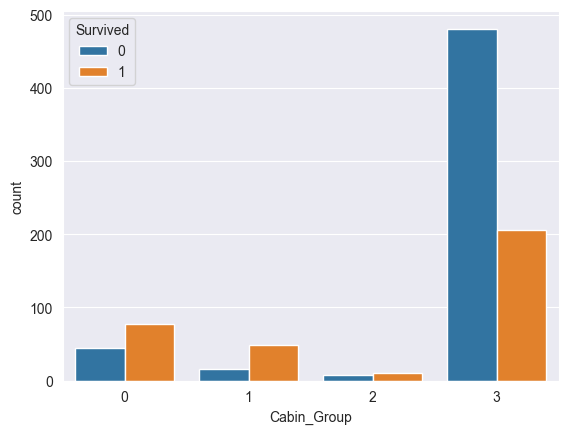

In [17]:
sns.countplot(data, x='Cabin_Group', hue='Survived')
plt.show()

In [18]:
ticket_sharing = {}
ticket_is_shared = {}

for index, row in data.iterrows():
    ticket = row['Ticket']
    shared_ticket = data[(data['Ticket'].str.contains(ticket)) & (index != data.index)]
    ticket_sharing[ticket] = len(shared_ticket)
    if len(shared_ticket) > 0:
        ticket_is_shared[ticket] = 1
    else:
        ticket_is_shared[ticket] = 0

In [19]:
ticket_sharing.values()

dict_values([0, 0, 0, 1, 0, 0, 0, 3, 2, 1, 1, 0, 0, 6, 0, 0, 4, 0, 0, 1, 1, 0, 0, 0, 3, 0, 3, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 5, 0, 2, 0, 0, 0, 0, 0, 2, 5, 0, 1, 1, 5, 0, 1, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1, 0, 0, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 3, 0, 1, 1, 0, 0, 3, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 2, 

In [20]:
data['Ticket_Sharing'] = data['Ticket'].apply(lambda x: ticket_sharing.get(x.split(',')[0]))
data['Ticket_is_Shared'] = data['Ticket'].apply(lambda x: ticket_is_shared.get(x.split(',')[0]))

In [21]:
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Has_Survived_Family,Family_Survival,Cabin_Group,Ticket_Sharing,Ticket_is_Shared
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,0,0,3,0,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,0,0,0,0,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,0,0,3,0,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,1,1,0,1,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Montvila,0,0,3,0,0
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Graham,1,1,0,0,0
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Johnston,0,0,3,1,1


In [22]:
class AgeGroupTransformer(BaseEstimator, TransformerMixin):
    def fit(self, df, ans=None):
        self.means = {}
        for i in df['Prefix'].unique():
            m = df[df['Prefix']==i]['Age'].median()
            self.means[i] = m
        return self

    def transform(self, df, ans=None):
        df1 = df.copy()
        index_values = df1.index.values.astype(int)
        for i in index_values:
            age = df1.at[i, 'Age'].astype(float)
            if np.isnan(age):
                title = df1.loc[i, 'Prefix']
                df1.loc[i, 'Age'] = round(self.means[title], 2)

        df1["AgeGroup"] = pd.cut(df1["Age"], bins=[-0.001, 16.336, 32.252, 48.168, 64.084, 80.0], labels=[0,1,2,3,4])
        df1["AgeGroup"] = df1["AgeGroup"].astype(int)

        return df1

In [95]:
def feature_selection_and_preprocessing(dataset: pd.DataFrame) -> pd.DataFrame:
    features = dataset[["Fare", 'Pclass', 'Age']].copy()
    features["Age"] = dataset.Age.fillna(28.)  # Почти единственное, что тут было, и, вроде как, не очень правильное, поэтому чуть-чуть хардкода, чтобы не выдавало ошибок
    features["Log_Fare"] = np.log(features["Fare"] + 1)
    features['Embarked'] = dataset.Embarked.fillna('S')
    features['Missing'] = dataset.isna().sum(axis=1)
    features['IsMale'] = np.where(dataset.Sex=='male', 1, 0)
    features['Companions'] = dataset.SibSp + dataset.Parch
    features['IsAlone'] = np.where((dataset.SibSp == 0) & (dataset.Parch == 0), 1, 0)
    features['Embarked_S'] = np.where(features.Embarked == 'S', 1, 0) # ДА, это ручной onehot
    features['Embarked_C'] = np.where(features.Embarked == 'C', 1 ,0)
    features.drop('Embarked', axis=1, inplace=True)
    features['Prefix'] = data.Name.apply(lambda x: x.split(',')[1].split('.')[0]).apply(
        lambda y: 'other' if y in (data.Name.apply(lambda x: x.split(',')[1].split('.')[0]).value_counts())
        [(data.Name.apply(lambda x: x.split(',')[1].split('.')[0]).value_counts() == 1)]
        else y)  # Вычленяем префиксы имен и заменяем те, что встречаются 1 раз на other (да, я знаю, что это можно сделать в разы более читаемо)
    features['Cabin_Group'] = dataset.Cabin.fillna('Z').apply(lambda x: x[0]).apply(lambda y: group_cabin(y)) # Вычленяем первую букву и превращаем в цифру в зависимости от группы

    return features

model = make_pipeline(
    # AgeGroupTransformer(),
    make_column_transformer(
        (SimpleImputer(strategy='median', copy=False), ['Age']), # Как я понимаю, с пропусками надо работать этой штукой, а не грубой вставкой из данных по всему датасету
        (OneHotEncoder(sparse_output=False), ['Prefix']),
        (PolynomialFeatures(5), ['Companions', 'Missing', 'Pclass', 'Fare', 'Log_Fare', 'Age']),
        remainder='passthrough'
    ),
    StandardScaler(),
    LogisticRegression(max_iter=10000, penalty='l1', solver='saga')
)
# Validation code (do not touch)
data_train, data_test = train_test_split(data, test_size=200, random_state=42)
model.fit(feature_selection_and_preprocessing(data_train.drop('Survived', axis=1)),data_train['Survived'])
train_predictions = model.predict(feature_selection_and_preprocessing(data_train.drop('Survived', axis=1)))
test_predictions = model.predict(feature_selection_and_preprocessing(data_test.drop('Survived', axis=1) ))
print("Train accuracy:", accuracy_score(data_train['Survived'],train_predictions))
print("Test accuracy:", accuracy_score(data_test['Survived'],test_predictions))

Train accuracy: 0.8451519536903039
Test accuracy: 0.84
